In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#training,testing
from sklearn.model_selection import train_test_split
#NLP
from sklearn.feature_extraction.text import TfidfVectorizer
#model
from sklearn.linear_model import LinearRegression
#loss and error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pytorch modules
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/home-depot-product-search-relevance/product_descriptions.csv.zip
/kaggle/input/home-depot-product-search-relevance/relevance_instructions.docx
/kaggle/input/home-depot-product-search-relevance/train.csv.zip
/kaggle/input/home-depot-product-search-relevance/sample_submission.csv.zip
/kaggle/input/home-depot-product-search-relevance/attributes.csv.zip
/kaggle/input/home-depot-product-search-relevance/test.csv.zip


In [2]:
 #Extracting zip files
!unzip /kaggle/input/home-depot-product-search-relevance/train.csv.zip
!unzip /kaggle/input/home-depot-product-search-relevance/test.csv.zip
!unzip /kaggle/input/home-depot-product-search-relevance/product_descriptions.csv.zip
!unzip /kaggle/input/home-depot-product-search-relevance/attributes.csv.zip

Archive:  /kaggle/input/home-depot-product-search-relevance/train.csv.zip
  inflating: train.csv               
Archive:  /kaggle/input/home-depot-product-search-relevance/test.csv.zip
  inflating: test.csv                
Archive:  /kaggle/input/home-depot-product-search-relevance/product_descriptions.csv.zip
  inflating: product_descriptions.csv  
Archive:  /kaggle/input/home-depot-product-search-relevance/attributes.csv.zip
  inflating: attributes.csv          


In [3]:
# Importing libraries
#feature engineering and others
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Loading data through pandas
training_data = pd.read_csv("/kaggle/working/train.csv", encoding="ISO-8859-1")
testing_data = pd.read_csv("/kaggle/working/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('/kaggle/working/attributes.csv')
descriptions_data = pd.read_csv('/kaggle/working/product_descriptions.csv')

print("training data shape is:",training_data.shape)
print("testing data shape is:",testing_data.shape)
print("attribute data shape is:",attribute_data.shape)
print("description data shape is:",descriptions_data.shape)

training data shape is: (74067, 5)
testing data shape is: (166693, 4)
attribute data shape is: (2044803, 3)
description data shape is: (124428, 2)


In [4]:
# Display a few rows of the loaded data
print("Training Data:")
print(training_data.head())
print("\nTesting Data:")
print(testing_data.head())
print("\nAttributes Data:")
print(attribute_data.head())
print("\nDescriptions Data:")
print(descriptions_data.head())

Training Data:
   id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

          search_term  relevance  
0       angle bracket       3.00  
1           l bracket       2.50  
2           deck over       3.00  
3    rain shower head       2.33  
4  shower only faucet       2.67  

Testing Data:
   id  product_uid                      product_title  \
0   1       100001  Simpson Strong-Tie 12-Gauge Angle   
1   4       100001  Simpson Strong-Tie 12-Gauge Angle   
2   5       100001  Simpson Strong-Tie 12-Gauge Angle   
3   6       100001  Simpson Strong-Tie 12-Gauge Angle   
4   7       100001  Simpson Strong-T

In [5]:
# Merge dataframes
train_data = pd.merge(training_data, descriptions_data, how='left', on='product_uid')
test_data = pd.merge(testing_data, descriptions_data, how='left', on='product_uid')

In [6]:
# Feature Engineering
# Combine relevant text data
train_data['text_data'] = train_data['search_term'] + ' ' + train_data['product_title'] + ' ' + train_data['product_description']
test_data['text_data'] = test_data['search_term'] + ' ' + test_data['product_title'] + ' ' + test_data['product_description']

In [7]:
#  let's assume X is the concatenation of product titles and descriptions
X = train_data['product_title'] + ' ' + descriptions_data['product_description']
y = train_data['relevance']

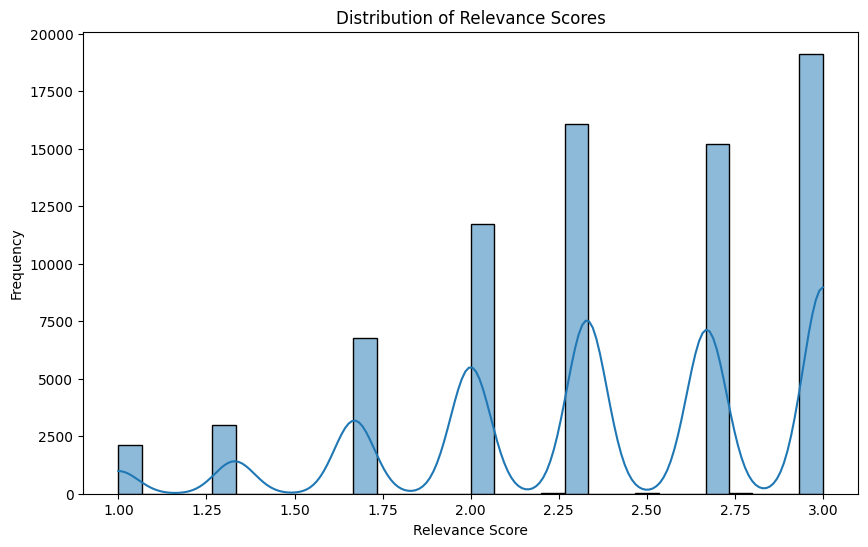

In [8]:
# EDA
# Explore distribution of relevance scores
plt.figure(figsize=(10, 6))
sns.histplot(train_data['relevance'], bins=30, kde=True)
plt.title('Distribution of Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

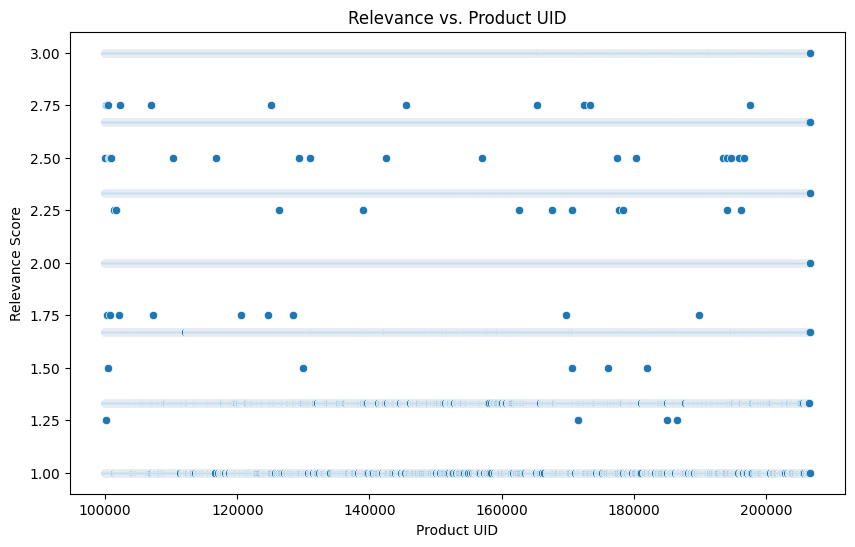

In [9]:

# Explore the relationship between relevance and other numerical features
plt.figure(figsize=(10, 6))
sns.scatterplot(x='product_uid', y='relevance', data=train_data)
plt.title('Relevance vs. Product UID')
plt.xlabel('Product UID')
plt.ylabel('Relevance Score')
plt.show()

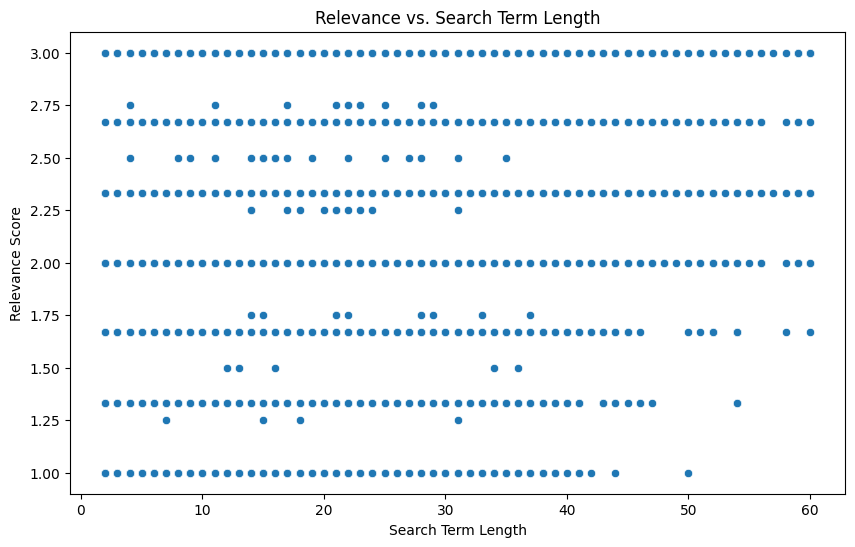

In [10]:

# Explore the relationship between relevance and the length of the search term
train_data['search_term_length'] = train_data['search_term'].apply(len)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='search_term_length', y='relevance', data=train_data)
plt.title('Relevance vs. Search Term Length')
plt.xlabel('Search Term Length')
plt.ylabel('Relevance Score')
plt.show()

# Deep learning approach

In [8]:
import torch
from transformers import BertTokenizer
import numpy as np

# Assuming X is your input data
# Replace NaN values with an empty string or any other appropriate strategy
X = X.dropna()

# Tokenize text data using BERT tokenizer in batches
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the maximum sequence length
max_seq_length = 128

# Define the batch size
batch_size = 32

# Get the total number of batches
num_batches = int(np.ceil(len(X) / batch_size))

# Initialize an empty list to store tokenized batches
X_tokenized_batches = []

# Tokenize in batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size

    # Get the current batch
    current_batch = X.iloc[start_idx:end_idx]

    # Tokenize the current batch
    current_batch_tokenized = current_batch.apply(lambda text: tokenizer.encode(text, add_special_tokens=True, truncation=True, padding='max_length', max_length=max_seq_length))

    # Convert to PyTorch tensor and append to the list
    X_tokenized_batches.append(torch.tensor(current_batch_tokenized.tolist()))

# Pad sequences within each batch to the maximum sequence length in that batch
X_tokenized_padded = torch.nn.utils.rnn.pad_sequence(X_tokenized_batches, batch_first=True)

# Print the shape of the resulting tensor
print("Shape of X_tokenized_padded:", X_tokenized_padded.shape)



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Shape of X_tokenized_padded: torch.Size([2315, 32, 128])


In [9]:
#converting textual data to numerical using Word2vec embedding
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import torch

# Assuming X is a list of lists, where each sublist represents a tokenized sentence
tokenized_sentences = X.tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to obtain vector representation for a sentence using Word2Vec
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else None

# Convert text data to Word2Vec embeddings
X_w2v = [get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences]
X_w2v = [torch.tensor(vector) if vector is not None else torch.zeros(word2vec_model.vector_size) for vector in X_w2v]
X_w2v = torch.stack(X_w2v)

# Now, X_w2v contains the Word2Vec embeddings for your text data


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_w2v and y are numpy arrays
# Make sure X_w2v and y have the same number of samples
min_samples = min(X_w2v.shape[0], y.shape[0])
X_w2v_subset = X_w2v[:min_samples]
y_subset = y[:min_samples]

# Split the data into training and validation sets
X_train_w2v, X_val_w2v, y_train, y_val = train_test_split(X_w2v_subset, y_subset, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_w2v_tensor = torch.tensor(X_train_w2v, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_w2v_tensor = torch.tensor(X_val_w2v, dtype=torch.float32)

# Convert y_val to a numpy array before creating the PyTorch tensor
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)



/tmp/ipykernel_42/3772747043.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_w2v_tensor = torch.tensor(X_train_w2v, dtype=torch.float32)
/tmp/ipykernel_42/3772747043.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_w2v_tensor = torch.tensor(X_val_w2v, dtype=torch.float32)


In [11]:
# Define training parameters
num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Define DataLoader for training and validation
train_dataset = TensorDataset(X_train_w2v_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_w2v_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

In [13]:

# Training and evaluation loop for SimpleNN
def train_simple_nn(model, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            epoch_val_losses = []
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_losses.append(loss.item())

            val_loss = np.mean(epoch_val_losses)
            val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Instantiate and train SimpleNN
simple_nn_model = SimpleNN(input_size=X_train_w2v_tensor.shape[1], hidden_size=64, output_size=1)
train_losses_simple_nn, val_losses_simple_nn = train_simple_nn(simple_nn_model, train_loader, val_loader, num_epochs, learning_rate)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1/10], Train Loss: 0.3564, Val Loss: 0.2871
Epoch [2/10], Train Loss: 0.2924, Val Loss: 0.2925
Epoch [3/10], Train Loss: 0.2906, Val Loss: 0.2894
Epoch [4/10], Train Loss: 0.2907, Val Loss: 0.2855
Epoch [5/10], Train Loss: 0.2897, Val Loss: 0.2863
Epoch [6/10], Train Loss: 0.2891, Val Loss: 0.2885
Epoch [7/10], Train Loss: 0.2900, Val Loss: 0.2864
Epoch [8/10], Train Loss: 0.2898, Val Loss: 0.2921
Epoch [9/10], Train Loss: 0.2890, Val Loss: 0.2843
Epoch [10/10], Train Loss: 0.2888, Val Loss: 0.2847


# Machine learning approach

In [14]:
# TF-IDF vectorization of text data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train_data['text_data'])
X_test_tfidf = vectorizer.transform(test_data['text_data'])

In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, train_data['relevance'], test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()

# Lists to store evaluation metrics
mse_list = []
mae_list = []

# Train the model for multiple iterations and store evaluation metrics
for i in range(2):  # You can adjust the number of iterations
    model.fit(X_train, y_train)
    
    # Model Evaluation on Validation Set
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)
    mae = mean_absolute_error(y_val, val_preds)
    
    mse_list.append(mse)
    mae_list.append(mae)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
# Plot the evaluation metrics over iterations
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(mse_list) + 1), mse_list, label='Mean Squared Error')
plt.plot(range(1, len(mae_list) + 1), mae_list, label='Mean Absolute Error')
plt.title('Model Evaluation Metrics Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
# Predictions on Test Set
test_preds = model.predict(X_test_tfidf)

# Save predictions to a CSV file
submission_df = pd.DataFrame({'id': test_data['id'], 'relevance': test_preds})
submission_df.to_csv('/kaggle/working/submission.csv', index=False)